# Dataset construction

In [1]:
import torch 
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.gridspec import GridSpec
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cityblock
import tkinter as tk
from tkinter import filedialog, messagebox

np.random.seed(1328)
torch.random.manual_seed(1328)
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']


In [2]:

#FUNZIONE PER CARICARE IL DATASET DI IMMAGINI

def load_images_from_subfolders(main_folder):
    data = []
    label_names = {}
    label_index = 0    
    # Loop through each subject folder
    for subject_folder in os.listdir(main_folder):
        subject_path = os.path.join(main_folder, subject_folder)
        if os.path.isdir(subject_path):
            # Loop through each letter subfolder
            for letter_folder in os.listdir(subject_path):  # Correzione qui
                letter_path = os.path.join(subject_path, letter_folder)
                if os.path.isdir(letter_path):
                    # Get or create a label index for the letter
                    if letter_folder not in label_names:
                        label_names[letter_folder] = label_index
                        label_index += 1
                    label = label_names[letter_folder]
                    
                    # Load each image in the letter subfolder
                    for filename in os.listdir(letter_path):
                        img = cv2.imread(os.path.join(letter_path, filename), cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (100, 100)) 
                            data.append({'image': img, 'label': label, 'letter': letter_folder, 'subject': subject_folder})
    
    return pd.DataFrame(data), label_names, class_names

def prepare_data(df):
    # Expand the dimensions of images to add the channel dimension
    df['image'] = df['image'].apply(lambda x: x[:, :, np.newaxis])
    
    # Convert labels to one-hot encoding
    labels = to_categorical(df['label'], num_classes=df['label'].nunique())
    df['label'] = list(labels)
    
    return df

#CREAZIONE TEST E TRAIN SET
def create_train_test_dataframe(df, test_size=0.2):
    # Split the dataset into training and testing sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, stratify=df['label'].apply(lambda x: np.argmax(x)))
    
    print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")
    
    return df_train, df_test

#PLOT CLASS DISTRIBUITION
def plot_class_distribution(df, title, alphabet):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 6))
    label_indices = df['label'].apply(lambda x: np.argmax(x))  # Get the original class indices
    label_counts = label_indices.value_counts().reindex(range(len(alphabet)), fill_value=0)
    
    ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)
    ax.set_title(f"Distribution of Samples in {title} Data", fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/distribution_{title}_data.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

#per plottare alcune immagini di esempio
def plot_sample_images(df_train, alphabet):
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig)  # Griglia 3x3

    # Convert one-hot encoded labels back to integers for uniqueness
    df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))
    unique_labels = df_train['label_int'].unique()[:3]  # Limita a 3 categorie

    for i, category in enumerate(unique_labels):
        sample_images = df_train[df_train['label_int'] == category].sample(min(3, len(df_train[df_train['label_int'] == category])))
        for j, (index, row) in enumerate(sample_images.iterrows()):
            ax = fig.add_subplot(gs[i, j])
            img = row['image'].reshape(100, 100)  # Assuming the images are 64x64
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.text(0.5, -0.1, alphabet[category], fontsize=25, color='black', ha='center', transform=ax.transAxes)
    plt.show()

In [3]:
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df_train, df_test = create_train_test_dataframe(df)

Train set: (14680, 4), Test set: (3671, 4)


C:\Users\orazi\AppData\Local\Temp\ipykernel_21688\2206875324.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


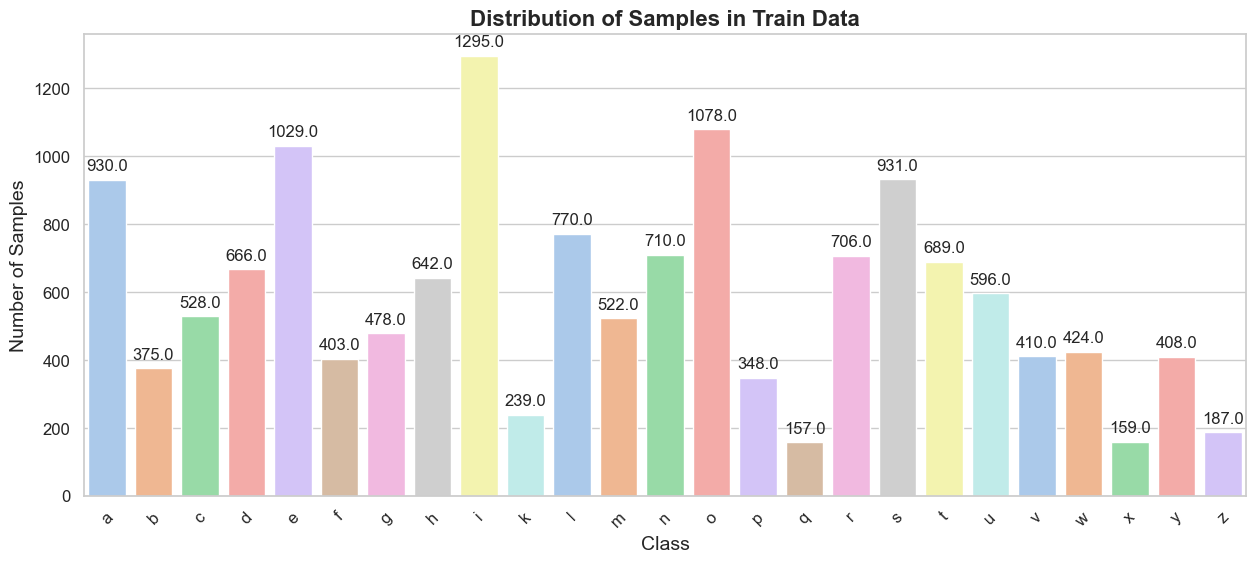

C:\Users\orazi\AppData\Local\Temp\ipykernel_21688\2206875324.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


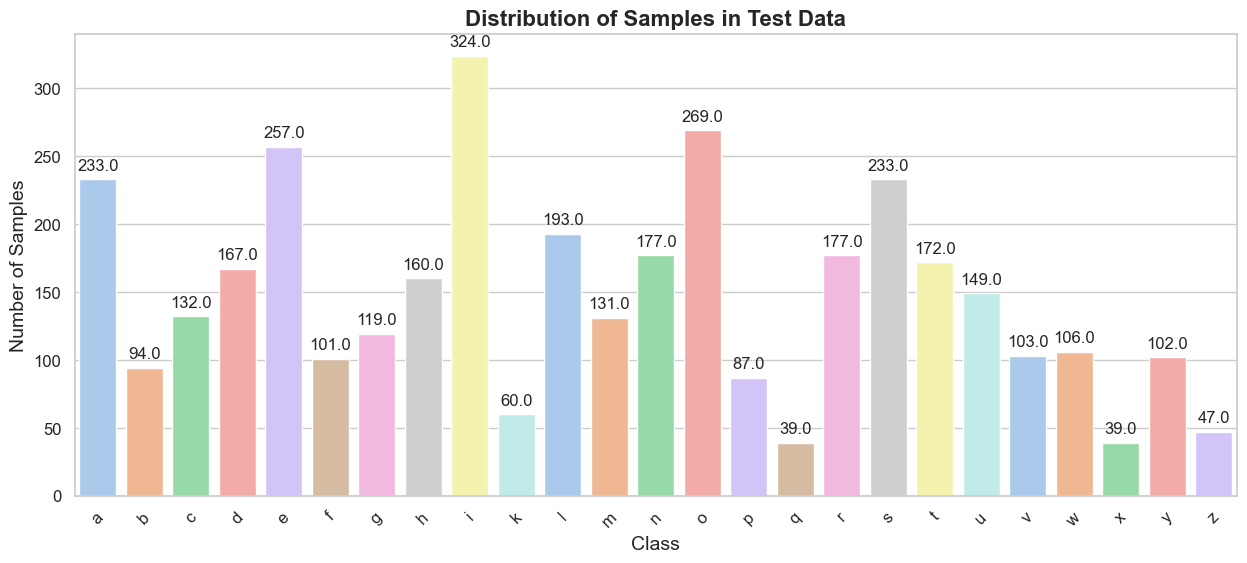

In [4]:
plot_class_distribution(df_train, 'Train', alphabet)
plot_class_distribution(df_test, 'Test', alphabet)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label_int'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)  
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')  
        label = row['label_int']

        if self.transform:
            image = self.transform(image)

        return image, label

def collate_fn(batch):
    images, labels, subjects = zip(*batch)
    return torch.stack(images), torch.tensor(labels), subjects

# Define transformations
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))

# Split dataset into training, testing, and validation
train_df, test_val_df = train_test_split(df_train, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (17616)
Shape: torch.Size([64, 3, 50, 50])
Validation Samples (2936)
Shape: torch.Size([64, 3, 50, 50])
Testing Samples (2936)
Shape: torch.Size([64, 3, 50, 50])


## Letter-Classifier model

In [7]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [8]:
class LetterClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=25, dropout_rate=0.5):
        super(LetterClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # convolutional layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # convolutional layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # convolutional layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # convolutional layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, num_classes) # output layer (fully connected)
        )

    def forward(self, x):
        return self.model(x)

    def numparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def train_model(self, train_loader, val_loader, exp_name='experiment', epochs=10, lr=0.001, momentum=0.9, weight_decay=1e-4, logdir='logs', verbose=True, save_model=True):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)  

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        loader = {'train': train_loader, 'val': val_loader}

        global_step = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0  
        patience = 20
        for e in range(epochs):
            print(f'[Epoch {e+1}/{epochs}]')
            for mode in ['train', 'val']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()

                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)

                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)

                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()

                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)

                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                    writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
                    writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)

                    if mode == 'train':
                        train_losses.append(loss_meter.value())
                        train_accuracies.append(acc_meter.value())
                    else:
                        val_losses.append(loss_meter.value())
                        val_accuracies.append(acc_meter.value())

                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            epochs_no_improve = 0  
                            if save_model:
                                torch.save(self.model.state_dict(), os.path.join('models', f'{exp_name}.pth'))
                                with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
                                    pickle.dump({
                                        'train_loss': train_losses, 
                                        'val_loss': val_losses,
                                        'train_accuracy': train_accuracies, 
                                        'val_accuracy': val_accuracies
                                    }, f)
                        else:
                            epochs_no_improve += 1 

            if verbose:
                print(f'Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.3f}\n')

            if epochs_no_improve == patience:
                print('Early stopping')
                break

        return train_losses, train_accuracies, val_losses, val_accuracies

    def test_model(self, test_loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        with torch.no_grad():
            for batch in test_loader:
                X = batch[0].to(device)
                y = batch[1].to(device)
                out = self.model(X)

                n = X.shape[0]
                l = loss_fn(out, y)

                loss_meter.add(l.item(), n)
                acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                acc_meter.add(acc, n)

        test_loss = loss_meter.value()
        test_accuracy = acc_meter.value()

        return test_loss, test_accuracy

    def test_error(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        predictions, labels = [], []  # Inizializza come liste vuote
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        error = (1 - accuracy_score(np.array(labels), np.array(predictions))) * 100
        return error
    
    def evaluate(self, test_loader):
        self.model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        return precision, recall, f1
    
    def confusion_matrix(self, test_loader):
        self.model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        return confusion_matrix(all_labels, all_preds)
    
    def plot_precision_recall_curve(self, test_loader, file_path=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.eval()
        self.to(device)
        
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        n_classes = all_labels_bin.shape[1]
        
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            
            auc_score = auc(recall, precision)
            print(f'AUC per la classe {i}: {auc_score:.3f}')


In [9]:
letter_classifier = LetterClassifier()
print(f'The model has {letter_classifier.numparams()} trainable parameters')

The model has 1582361 trainable parameters


## Train the model

In [10]:
lr = 0.001
momentum = 0.9
weight_decay = 0.0001
dropout_rate = 0.2

exp_name = 'letter_classifier_1'
epochs = 200

letter_classifier = LetterClassifier()

'''
train_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,
                                                                                          val_loader,
                                                                                          exp_name=exp_name,
                                                                                          epochs=epochs,
                                                                                          lr=lr,
                                                                                          momentum=momentum,
                                                                                          weight_decay=weight_decay)
'''

'\ntrain_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,\n                                                                                          val_loader,\n                                                                                          exp_name=exp_name,\n                                                                                          epochs=epochs,\n                                                                                          lr=lr,\n                                                                                          momentum=momentum,\n                                                                                          weight_decay=weight_decay)\n'

## Test the model

In [31]:
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
letter_classifier.model.eval()

with torch.no_grad():
    test_loss, test_accuracy = letter_classifier.test_model(test_loader)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 0.778, Test Accuracy: 0.767


In [32]:
test_error = letter_classifier.test_error(test_loader)
print(f"Error percentage: {test_error:.2f} %")

Error percentage: 23.26 %


In [33]:
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Add the new metrics
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

# Save the updated metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

Metrics updated and saved successfully


## After model selection 

In [34]:
# Load the model
letter_classifier = LetterClassifier()
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
print("Model loaded successfully")

# Load metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

# Convert the metrics to float and round to 3 decimal places
train_losses = [round(float(i), 3) for i in metrics['train_loss']]
val_losses = [round(float(i), 3) for i in metrics['val_loss']]
train_accuracies = [round(float(i), 3) for i in metrics['train_accuracy']]
val_accuracies = [round(float(i), 3) for i in metrics['val_accuracy']]
test_loss = round(float(metrics['test_loss']), 3)
test_accuracy = round(float(metrics['test_accuracy']), 3)
test_error = round(float(metrics['test_error']), 2)

print(f"Best epoch: {len(val_losses)}/{epochs}\n")
print(f"Train Loss: {train_losses[-1]}")
print(f"Train Accuracy: {train_accuracies[-1]}\n")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Validation Accuracy: {val_accuracies[-1]}\n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}%")

Model loaded successfully
Metrics loaded successfully

Best epoch: 135/200

Train Loss: 1.837
Train Accuracy: 0.46

Validation Loss: 0.793
Validation Accuracy: 0.776

Test Loss: 0.778
Test Accuracy: 0.767
Test Error: 23.26%


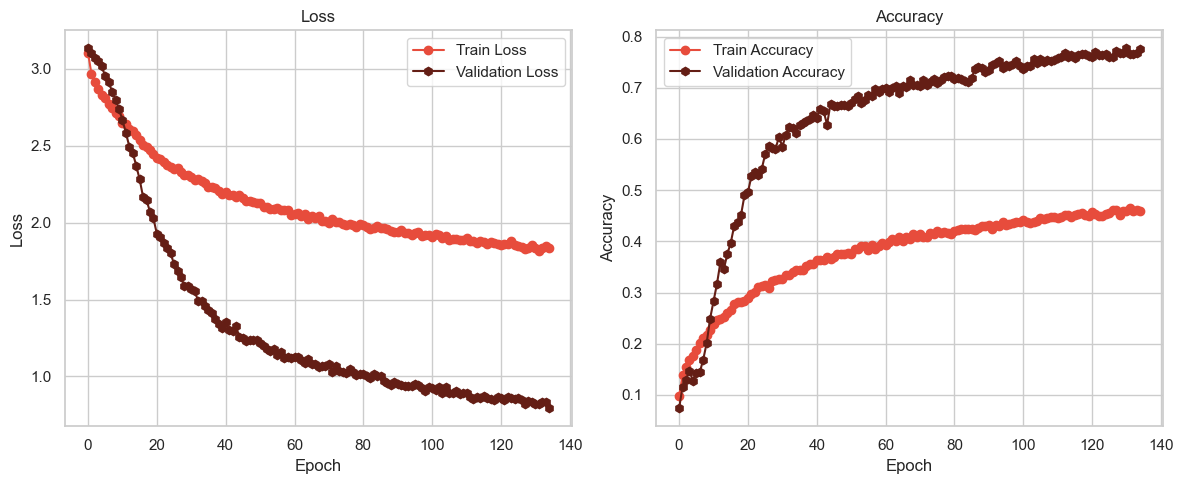

In [35]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

In [36]:
precision, recall, f1 = letter_classifier.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.769
Recall: 0.736
F1 Score: 0.744


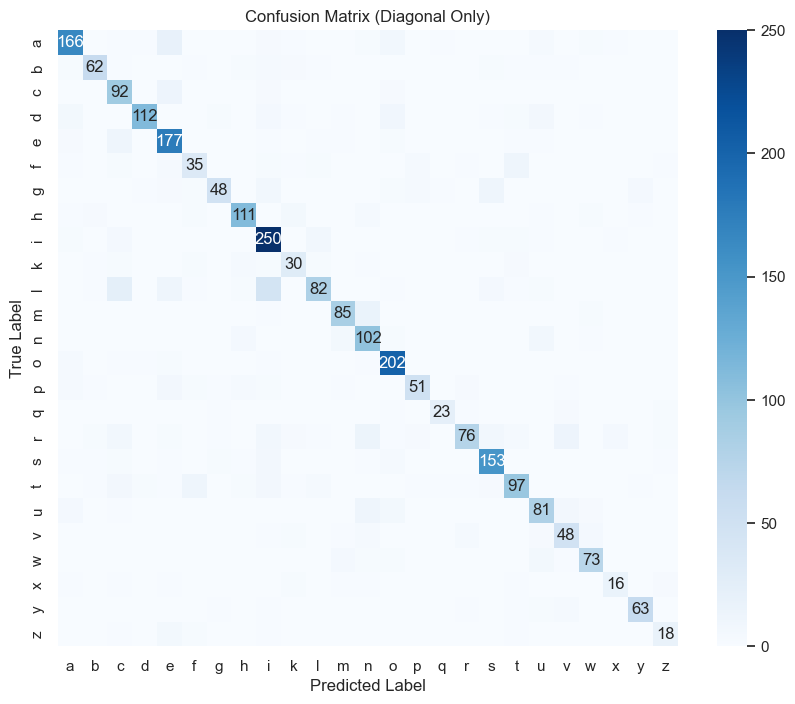

In [37]:
cm = letter_classifier.confusion_matrix(test_loader) 

def plot_confusion_matrix(cm, class_names, file_path=None):
    # Creiamo un array di annotazioni vuoto
    annot = np.full_like(cm, '', dtype=object)
    
    # Popoliamo l'array di annotazioni solo con i valori della diagonale principale
    for i in range(len(cm)):
        annot[i, i] = f'{cm[i, i]}'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Diagonal Only)')
    if file_path:
        plt.savefig(file_path)
    plt.show()

plot_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

In [38]:
letter_classifier.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')


AUC per la classe 0: 0.907
AUC per la classe 1: 0.876
AUC per la classe 2: 0.811
AUC per la classe 3: 0.947
AUC per la classe 4: 0.919
AUC per la classe 5: 0.524
AUC per la classe 6: 0.777
AUC per la classe 7: 0.919
AUC per la classe 8: 0.892
AUC per la classe 9: 0.724
AUC per la classe 10: 0.790
AUC per la classe 11: 0.912
AUC per la classe 12: 0.851
AUC per la classe 13: 0.975
AUC per la classe 14: 0.813
AUC per la classe 15: 0.818
AUC per la classe 16: 0.834
AUC per la classe 17: 0.932
AUC per la classe 18: 0.796
AUC per la classe 19: 0.765
AUC per la classe 20: 0.691
AUC per la classe 21: 0.855
AUC per la classe 22: 0.617
AUC per la classe 23: 0.937
AUC per la classe 24: 0.758


## Comparison with Noted Models in the Literature

In [10]:
from torchvision.models import alexnet, vgg16, googlenet, resnet18, squeezenet1_0, AlexNet_Weights, VGG16_Weights, GoogLeNet_Weights, ResNet18_Weights, SqueezeNet1_0_Weights

class GenericModel(LetterClassifier):

    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'alexnet':
            model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'vgg':
            model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'googlenet':
            model = googlenet(weights=GoogLeNet_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
        elif model_architecture == 'squeezenet':
            model = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)
            model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

    def extract_features(self, x):
        self.model.eval()
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features



## Reload datasets

In [11]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Split dataset into training, testing, and validation
train_df = df_train
test_df, val_df = train_test_split(df_test, test_size=0.2, random_state=42)

# Add 'label_int' column to test and validation dataframes
test_df['label_int'] = test_df['label'].apply(lambda x: np.argmax(x))
val_df['label_int'] = val_df['label'].apply(lambda x: np.argmax(x))

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (29360)
Shape: torch.Size([64, 3, 224, 224])
Validation Samples (735)
Shape: torch.Size([64, 3, 224, 224])
Testing Samples (2936)
Shape: torch.Size([64, 3, 224, 224])


## AlexNet

In [23]:
alexnet = GenericModel('alexnet')
print(f'The model has {alexnet.numparams()} trainable parameters')

The model has 57106265 trainable parameters


In [14]:
alexnet.eval()
with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)
    
print('\nNon fine-tuned AlexNet:')
print(f'Test Loss: {alexnet_test_loss:.3f}, Test Accuracy: {alexnet_test_accuracy:.3f}')


Non fine-tuned AlexNet:
Test Loss: 3.335, Test Accuracy: 0.036


In [43]:

lr = 0.001 
momentum = 0.9
weight_decay = 0.0001 
exp_name = 'alexnet_experiment1'

alexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, 
                                                                                                                 val_loader,
                                                                                                                 exp_name=exp_name, 
                                                                                                                 epochs=100,
                                                                                                                 lr=lr,
                                                                                                                 momentum=momentum,
                                                                                                                 weight_decay=weight_decay)


[Epoch 1/100]
Train Loss: 2.220, Train Accuracy: 0.351 | Val Loss: 1.048, Val Accuracy: 0.684

[Epoch 2/100]
Train Loss: 1.764, Train Accuracy: 0.481 | Val Loss: 0.813, Val Accuracy: 0.741

[Epoch 3/100]
Train Loss: 1.610, Train Accuracy: 0.523 | Val Loss: 0.751, Val Accuracy: 0.755

[Epoch 4/100]
Train Loss: 1.523, Train Accuracy: 0.546 | Val Loss: 0.687, Val Accuracy: 0.773

[Epoch 5/100]
Train Loss: 1.456, Train Accuracy: 0.565 | Val Loss: 0.608, Val Accuracy: 0.810

[Epoch 6/100]
Train Loss: 1.403, Train Accuracy: 0.583 | Val Loss: 0.629, Val Accuracy: 0.789

[Epoch 7/100]
Train Loss: 1.343, Train Accuracy: 0.599 | Val Loss: 0.604, Val Accuracy: 0.814

[Epoch 8/100]
Train Loss: 1.321, Train Accuracy: 0.609 | Val Loss: 0.598, Val Accuracy: 0.823

[Epoch 9/100]
Train Loss: 1.289, Train Accuracy: 0.615 | Val Loss: 0.570, Val Accuracy: 0.823

[Epoch 10/100]
Train Loss: 1.271, Train Accuracy: 0.620 | Val Loss: 0.571, Val Accuracy: 0.822

[Epoch 11/100]
Train Loss: 1.253, Train Accuracy:

In [45]:
exp_name = 'alexnet_experiment1'

alexnet.eval()

with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)

test_error = alexnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = alexnet_test_loss
metrics['test_accuracy'] = alexnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")


# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned AlexNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned AlexNet:
Train Loss: 0.939
Train Accuracy: 0.715

Validation Loss: 0.371
Validation Accuracy: 0.882

Test Loss: 0.4
Test Accuracy: 0.88


Precision: 0.887
Recall: 0.883
F1 Score: 0.883


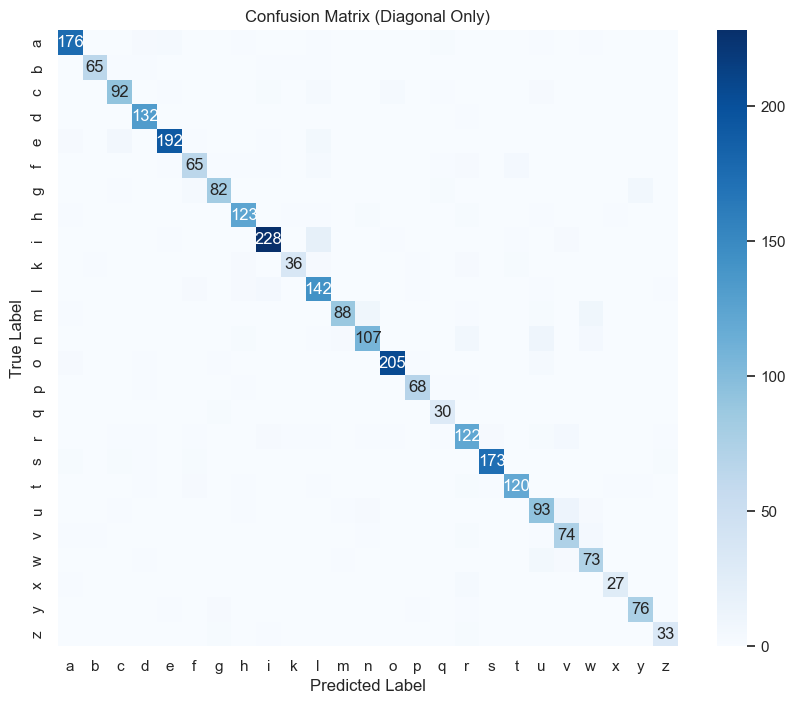

AUC per la classe 0: 0.983
AUC per la classe 1: 0.983
AUC per la classe 2: 0.935
AUC per la classe 3: 0.988
AUC per la classe 4: 0.973
AUC per la classe 5: 0.869
AUC per la classe 6: 0.959
AUC per la classe 7: 0.958
AUC per la classe 8: 0.971
AUC per la classe 9: 0.876
AUC per la classe 10: 0.933
AUC per la classe 11: 0.945
AUC per la classe 12: 0.901
AUC per la classe 13: 0.992
AUC per la classe 14: 0.979
AUC per la classe 15: 0.960
AUC per la classe 16: 0.903
AUC per la classe 17: 0.985
AUC per la classe 18: 0.956
AUC per la classe 19: 0.866
AUC per la classe 20: 0.872
AUC per la classe 21: 0.898
AUC per la classe 22: 0.936
AUC per la classe 23: 0.974
AUC per la classe 24: 0.907


In [46]:
precision, recall, f1 = alexnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = alexnet.confusion_matrix(test_loader) 

plot_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

alexnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## GoogleNet

In [32]:
googlenet = GenericModel('googlenet')
print(f'The model has {googlenet.numparams()} trainable parameters')

The model has 5625529 trainable parameters


In [33]:
googlenet.eval()
with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)
    
print('\nNon fine-tuned GoogleNet:')
print(f'Test Loss: {googlenet_test_loss:.3f}, Test Accuracy: {googlenet_test_accuracy:.3f}')


Non fine-tuned GoogleNet:
Test Loss: 3.274, Test Accuracy: 0.060


In [34]:
exp_name = 'googlenet_experiment'


googlenet_train_losses, googlenet_train_accuracies, googlenet_val_losses, googlenet_val_accuracies = googlenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=10,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)


[Epoch 1/10]
Train Loss: 3.007, Train Accuracy: 0.120 | Val Loss: 2.864, Val Accuracy: 0.181

[Epoch 2/10]
Train Loss: 2.753, Train Accuracy: 0.220 | Val Loss: 2.571, Val Accuracy: 0.340

[Epoch 3/10]
Train Loss: 2.514, Train Accuracy: 0.289 | Val Loss: 2.245, Val Accuracy: 0.379

[Epoch 4/10]
Train Loss: 2.302, Train Accuracy: 0.350 | Val Loss: 1.943, Val Accuracy: 0.465

[Epoch 5/10]
Train Loss: 2.107, Train Accuracy: 0.397 | Val Loss: 1.663, Val Accuracy: 0.552

[Epoch 6/10]
Train Loss: 1.939, Train Accuracy: 0.443 | Val Loss: 1.436, Val Accuracy: 0.607

[Epoch 7/10]
Train Loss: 1.829, Train Accuracy: 0.474 | Val Loss: 1.267, Val Accuracy: 0.641

[Epoch 8/10]
Train Loss: 1.744, Train Accuracy: 0.498 | Val Loss: 1.128, Val Accuracy: 0.694

[Epoch 9/10]
Train Loss: 1.664, Train Accuracy: 0.518 | Val Loss: 1.005, Val Accuracy: 0.749

[Epoch 10/10]
Train Loss: 1.592, Train Accuracy: 0.539 | Val Loss: 0.915, Val Accuracy: 0.752



In [17]:
exp_name = 'googlenet_experiment'
googlenet.eval()

with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)

test_error = googlenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = googlenet_test_loss
metrics['test_accuracy'] = googlenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
googlenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned GoogleNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

AttributeError: 'function' object has no attribute 'eval'

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.106
Recall: 0.082
F1 Score: 0.070


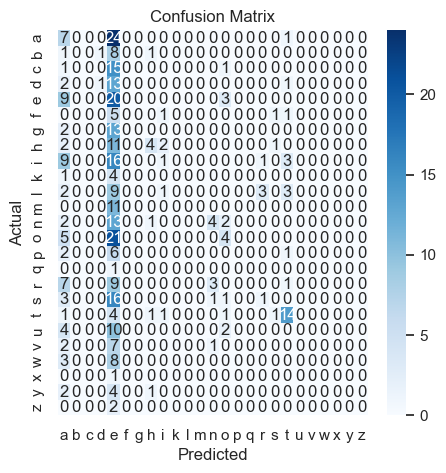

AUC per la classe a: 0.132
AUC per la classe b: 0.077
AUC per la classe c: 0.059
AUC per la classe d: 0.296
AUC per la classe e: 0.178
AUC per la classe f: 0.042
AUC per la classe g: 0.164
AUC per la classe h: 0.143
AUC per la classe i: 0.411
AUC per la classe k: 0.017
AUC per la classe l: 0.182
AUC per la classe m: 0.325
AUC per la classe n: 0.320
AUC per la classe o: 0.228
AUC per la classe p: 0.025
AUC per la classe q: 0.083
AUC per la classe r: 0.124
AUC per la classe s: 0.344
AUC per la classe t: 0.486
AUC per la classe u: 0.053
AUC per la classe v: 0.028
AUC per la classe w: 0.070
AUC per la classe x: 0.012
AUC per la classe y: 0.042
AUC per la classe z: 0.010


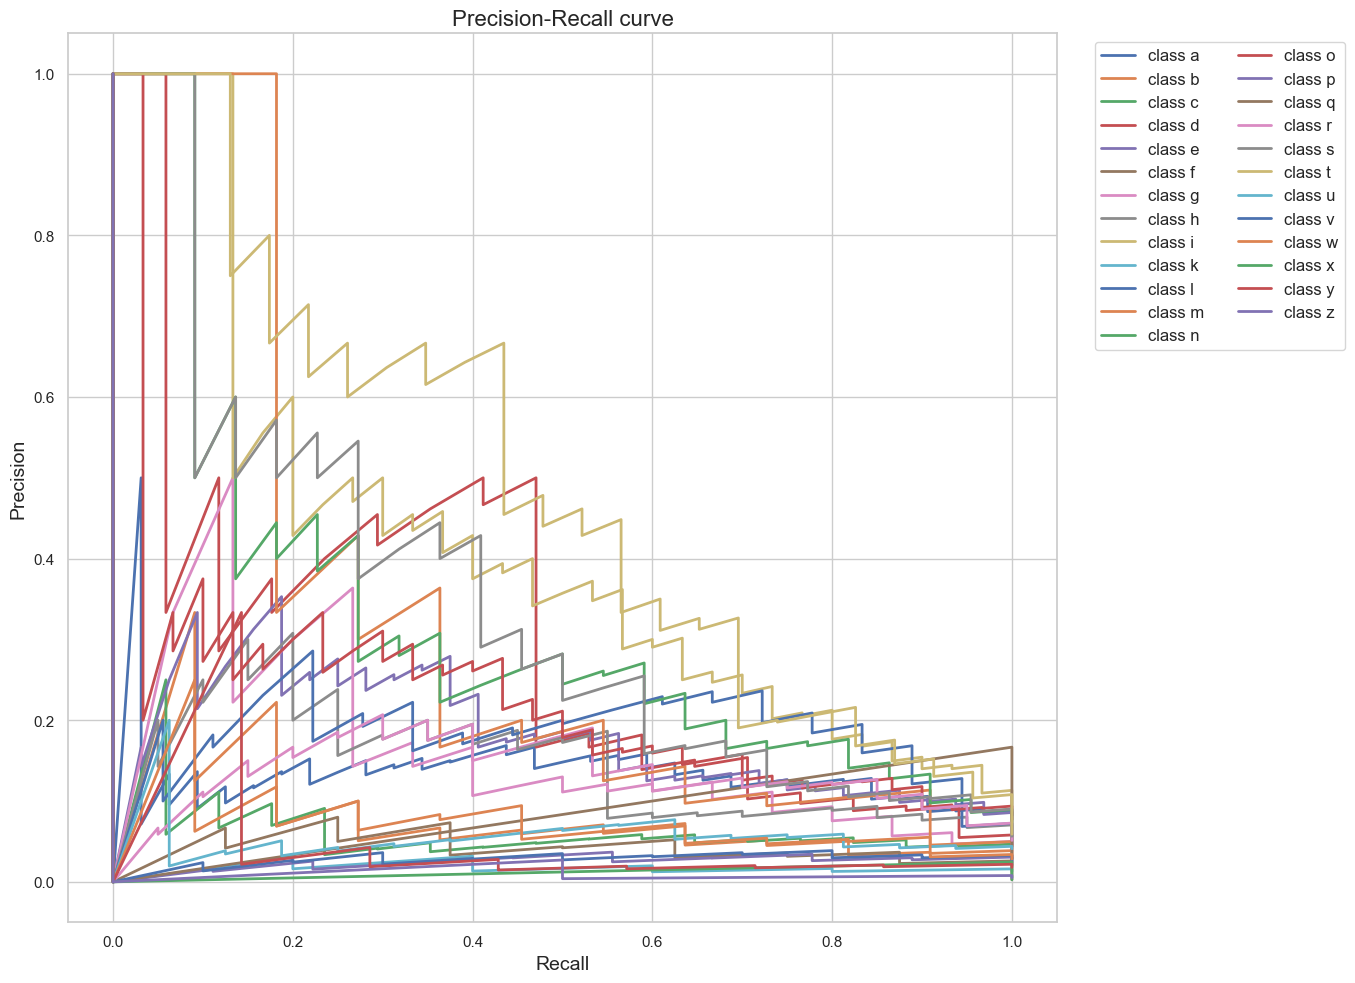

In [ ]:
precision, recall, f1 = googlenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = googlenet.confusion_matrix(test_loader) 

plot_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

googlenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## ResNet

In [13]:
resnet = GenericModel('resnet')
print(f'The model has {resnet.numparams()} trainable parameters')

The model has 11189337 trainable parameters


In [14]:
resnet.eval()
with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {resnet_test_loss:.3f}, Test Accuracy: {resnet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.457, Test Accuracy: 0.032


In [15]:

lr = 0.001 
momentum = 0.9
weight_decay = 0.0001 
exp_name = 'resnet_experiment7' 

'''
resnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies = resnet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=1000,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

[Epoch 1/1000]
Train Loss: 2.228, Train Accuracy: 0.364 | Val Loss: 1.211, Val Accuracy: 0.672

[Epoch 2/1000]
Train Loss: 1.540, Train Accuracy: 0.551 | Val Loss: 0.802, Val Accuracy: 0.762

[Epoch 3/1000]
Train Loss: 1.327, Train Accuracy: 0.608 | Val Loss: 0.717, Val Accuracy: 0.773

[Epoch 4/1000]
Train Loss: 1.230, Train Accuracy: 0.635 | Val Loss: 0.667, Val Accuracy: 0.788

[Epoch 5/1000]
Train Loss: 1.170, Train Accuracy: 0.649 | Val Loss: 0.623, Val Accuracy: 0.811

[Epoch 6/1000]
Train Loss: 1.124, Train Accuracy: 0.665 | Val Loss: 0.579, Val Accuracy: 0.816

[Epoch 7/1000]
Train Loss: 1.088, Train Accuracy: 0.672 | Val Loss: 0.618, Val Accuracy: 0.800

[Epoch 8/1000]
Train Loss: 1.038, Train Accuracy: 0.687 | Val Loss: 0.572, Val Accuracy: 0.816

[Epoch 9/1000]
Train Loss: 1.016, Train Accuracy: 0.691 | Val Loss: 0.543, Val Accuracy: 0.816

[Epoch 10/1000]
Train Loss: 0.981, Train Accuracy: 0.705 | Val Loss: 0.580, Val Accuracy: 0.808

[Epoch 11/1000]
Train Loss: 0.970, Trai

In [18]:

exp_name = 'resnet_experiment7'
resnet.eval()

with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)

test_error = resnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = resnet_test_loss
metrics['test_accuracy'] = resnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")


Metrics updated and saved successfully


In [19]:
# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

Model loaded successfully
Metrics loaded successfully



In [20]:
print('Fine-tuned ResNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Fine-tuned ResNet:
Train Loss: 0.795
Train Accuracy: 0.756

Validation Loss: 0.464
Validation Accuracy: 0.846

Test Loss: 0.506
Test Accuracy: 0.847


Precision: 0.860
Recall: 0.809
F1 Score: 0.827


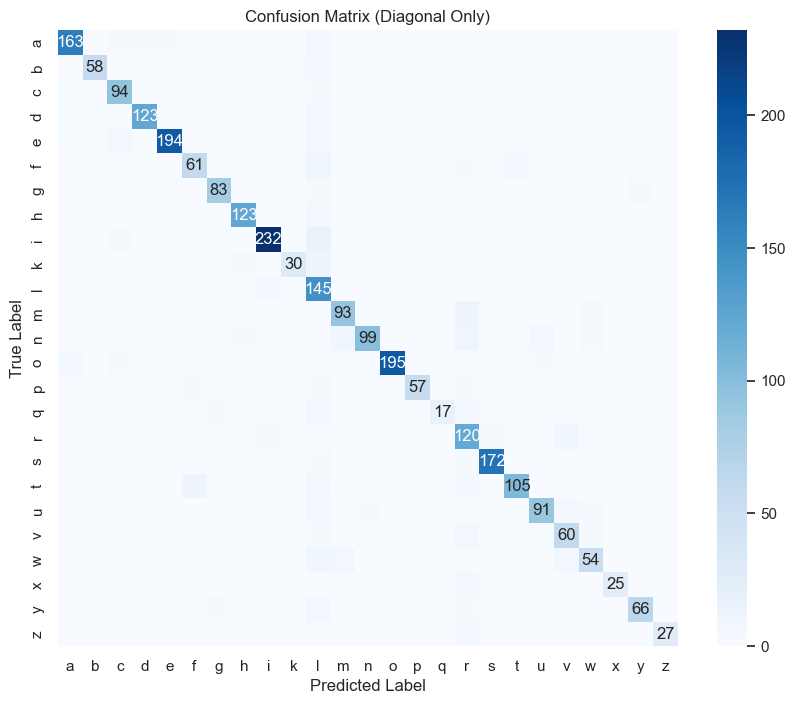

AUC per la classe 0: 0.963
AUC per la classe 1: 0.931
AUC per la classe 2: 0.958
AUC per la classe 3: 0.981
AUC per la classe 4: 0.977
AUC per la classe 5: 0.808
AUC per la classe 6: 0.938
AUC per la classe 7: 0.962
AUC per la classe 8: 0.965
AUC per la classe 9: 0.760
AUC per la classe 10: 0.918
AUC per la classe 11: 0.920
AUC per la classe 12: 0.898
AUC per la classe 13: 0.993
AUC per la classe 14: 0.940
AUC per la classe 15: 0.728
AUC per la classe 16: 0.894
AUC per la classe 17: 0.982
AUC per la classe 18: 0.904
AUC per la classe 19: 0.865
AUC per la classe 20: 0.838
AUC per la classe 21: 0.811
AUC per la classe 22: 0.896
AUC per la classe 23: 0.908
AUC per la classe 24: 0.801


In [21]:

precision, recall, f1 = resnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = resnet.confusion_matrix(test_loader) 

def plot_confusion_matrix(cm, class_names, file_path=None):
    # Creiamo un array di annotazioni vuoto
    annot = np.full_like(cm, '', dtype=object)
    
    # Popoliamo l'array di annotazioni solo con i valori della diagonale principale
    for i in range(len(cm)):
        annot[i, i] = f'{cm[i, i]}'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Diagonal Only)')
    if file_path:
        plt.savefig(file_path)
    plt.show()

plot_confusion_matrix(cm, class_names, file_path='plots/resnet_confusion_matrix.png')



resnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')


<h1>SqueezeNet</h1>

In [ ]:
squeezenet = GenericModel('squeezenet')
print(f'The model has {squeezenet.numparams()} trainable parameters')

In [ ]:
squeezenet.eval()
with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {squeezenet_test_loss:.3f}, Test Accuracy: {squeezenet_test_accuracy:.3f}')

In [ ]:
'''
lr = 0.001 
momentum = 0.9
weight_decay = 0.001 
exp_name = 'squeezenet_experiment'


squeezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=20,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

In [ ]:
exp_name = 'squeezenet_experiment'
squeezenet.eval()

with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)

test_error = squeezenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = squeezenet_test_loss
metrics['test_accuracy'] = squeezenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
squeezenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned SqueezeNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

In [ ]:
precision, recall, f1 = squeezenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = squeezenet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

squeezenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

<h1>Testing<h1>

Model loaded successfully


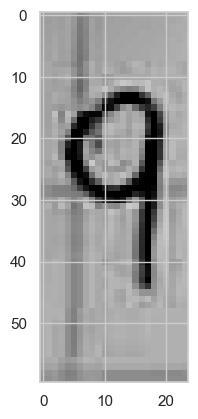

The image is classified as: q


In [27]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Funzione per caricare e trasformare l'immagine
def load_image(image_path, device):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    plt.imshow(image)
    plt.show()
    image = transform(image).unsqueeze(0).to(device)  
    return image

# Funzione per classificare l'immagine
def classify_image(image_path, model, class_names, device):
    image = load_image(image_path, device)
    model.eval() 
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_name = class_names[predicted.item()]
        return class_name

# Carica il modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights = torch.load(os.path.join('models', 'resnet_experiment6.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
resnet.to(device)  # Sposta il modello sulla device corretta
print("Model loaded successfully")

# Path dell'immagine da classificare
image_path = 'dataset/soggetto15/q/q_ajpg_character_41.png'

# Classifica l'immagine
class_name = classify_image(image_path, resnet, class_names, device)
print(f'The image is classified as: {class_name}')


<h1>classificazione di caratteri in cartelle</h1>

In [22]:
import os
import shutil
from PIL import Image
import torch
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

def load_image(image_path, device):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image).unsqueeze(0).to(device) 
    return image

# Function to classify an image and return class name and confidence
def classify_image(image_path, model, class_names, device):
    image = load_image(image_path, device)
    model.eval()  
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        class_name = class_names[predicted.item()]
        return class_name, confidence.item()

# Function to calculate dynamic thresholds based on confidences
def calculate_dynamic_thresholds(confidences, class_names, sigma_factor=1):
    confidence_dict = {i: [] for i in range(len(class_names))}
    
    for predicted_class, confidence in confidences:
        class_idx = class_names.index(predicted_class)
        confidence_dict[class_idx].append(confidence)
    
    thresholds = {}
    for class_idx, scores in confidence_dict.items():
        if scores:
            mean_conf = np.mean(scores)
            std_conf = np.std(scores)
            thresholds[class_idx] = max(0.5, mean_conf - sigma_factor * std_conf)
        else:
            thresholds[class_idx] = 0.5  

    return thresholds

# Function to gather confidences for all images in a directory
def gather_confidences(main_folder, model, class_names, device):
    confidences = []

    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith('.png'):
                predicted_class, confidence = classify_image(image_path, model, class_names, device)
                confidences.append((predicted_class, confidence))

    return confidences

# Function to classify images in a directory
def classify_images_in_directory(main_folder, output_folder, model, class_names, dynamic_thresholds, device):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    low_confidence_folder = os.path.join(output_folder, 'low_confidence')
    if not os.path.exists(low_confidence_folder):
        os.makedirs(low_confidence_folder)
    
    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith(('.jpg','.png')):
                class_name, confidence = classify_image(image_path, model, class_names, device)
                class_idx = class_names.index(class_name)
                confidence_threshold = dynamic_thresholds.get(class_idx, 0.5)
                if confidence < confidence_threshold:
                    dest_folder = low_confidence_folder
                else:
                    dest_folder = os.path.join(output_folder, class_name)
                if not os.path.exists(dest_folder):
                    os.makedirs(dest_folder)
                shutil.copy(image_path, os.path.join(dest_folder, file))

# Load the model and weights
model_weights = torch.load(os.path.join('models', 'alexnet_experiment1.pth'), map_location=device)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
resnet.to(device)  # Move the model to the correct device
print("Model loaded successfully")

main_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\dataset'
output_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\soggetto28'

class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

confidences = gather_confidences(main_folder, resnet, class_names, device)

dynamic_thresholds = calculate_dynamic_thresholds(confidences, class_names)

classify_images_in_directory(main_folder, output_folder, resnet, class_names, dynamic_thresholds, device)


Model loaded successfully


In [25]:
manuscript = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\dataset'
df, label_names, alphabet = load_images_from_subfolders(manuscript)

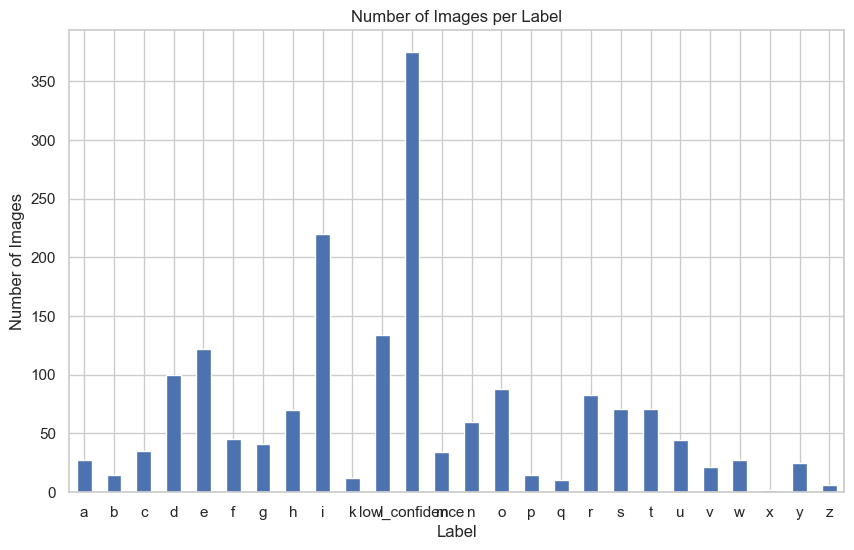

In [26]:
# Group by the label column and count the occurrences
label_counts = df['letter'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Number of Images per Label')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

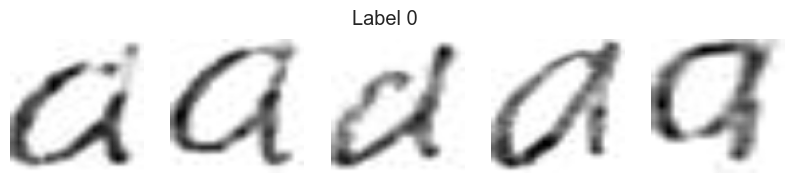

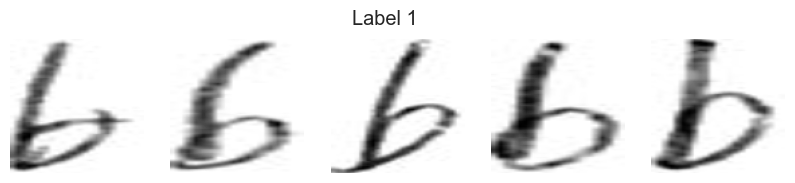

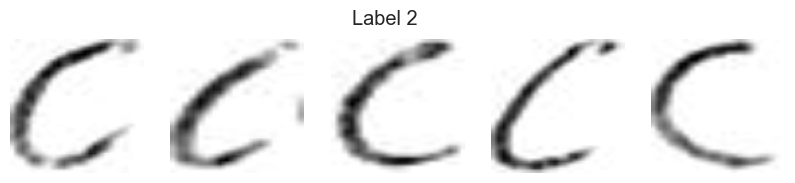

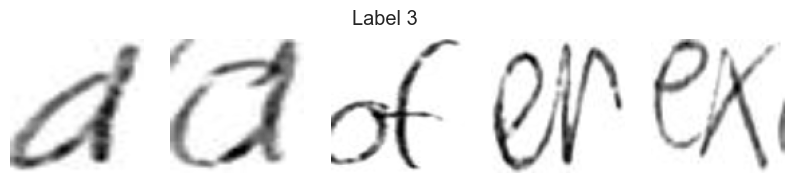

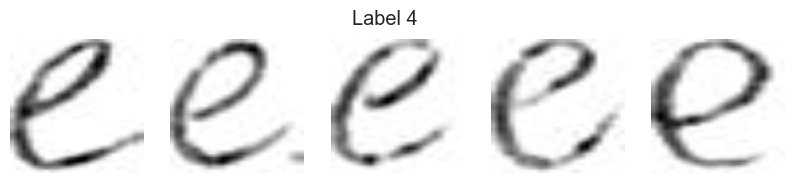

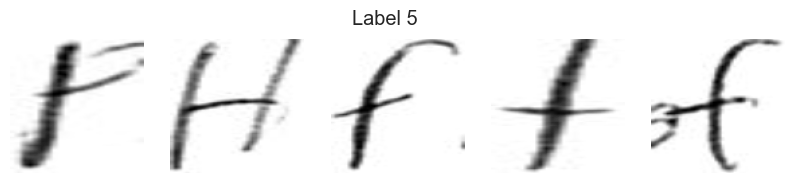

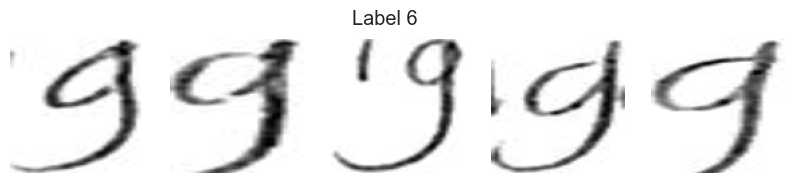

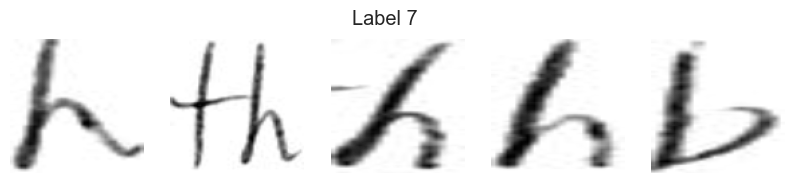

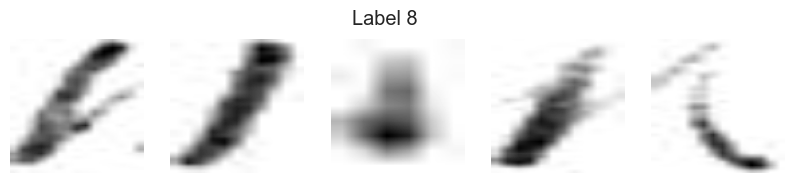

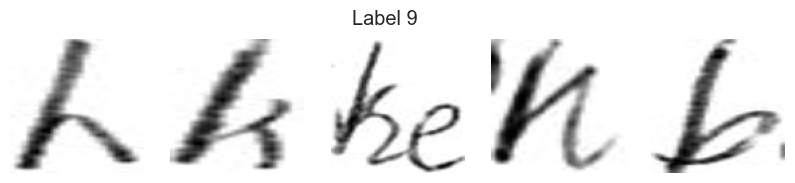

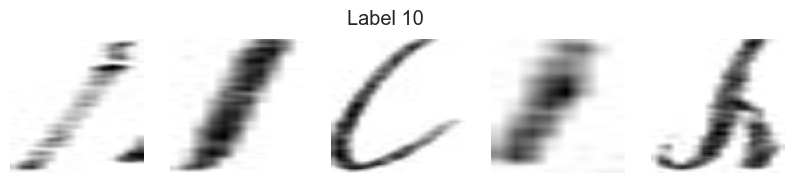

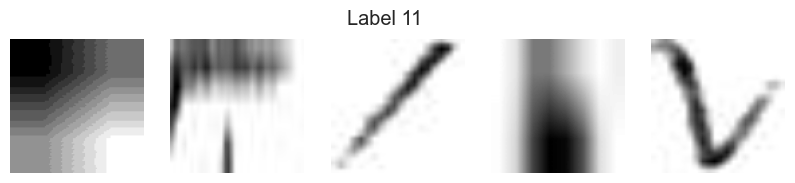

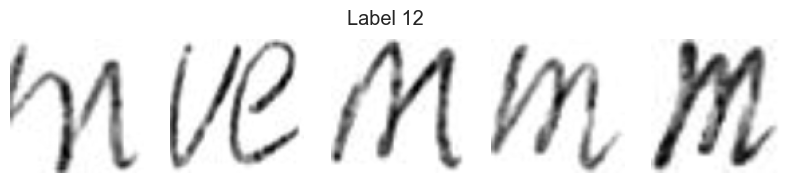

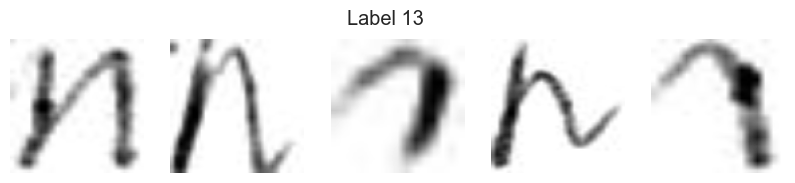

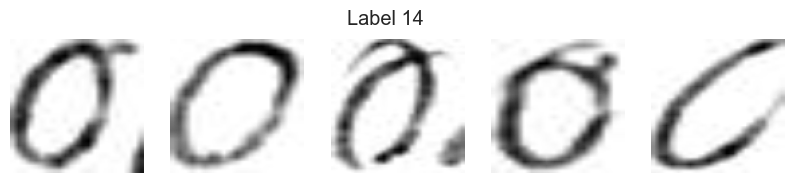

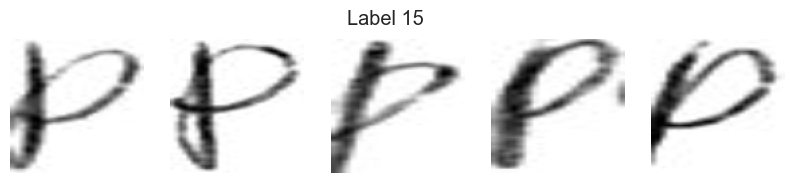

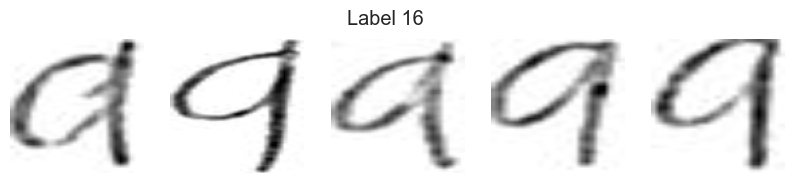

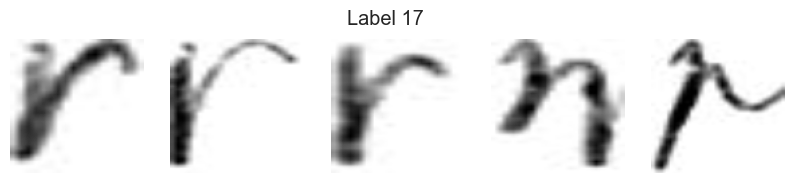

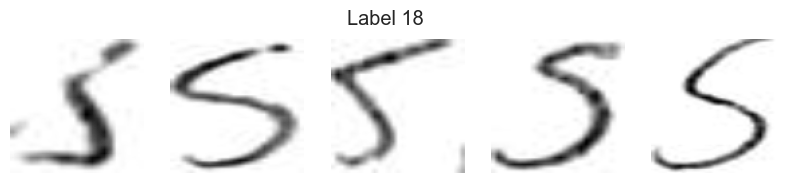

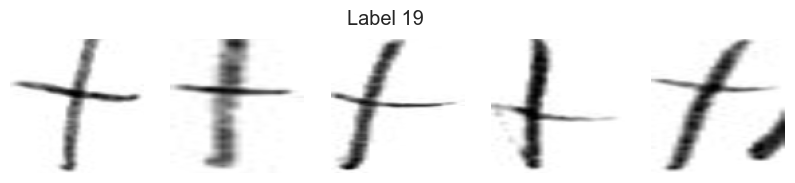

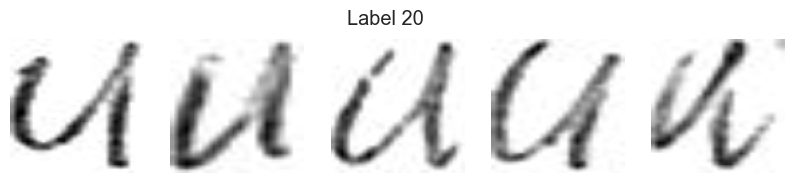

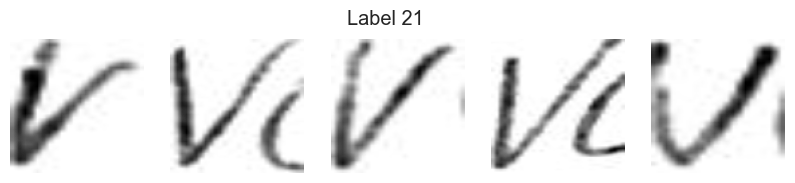

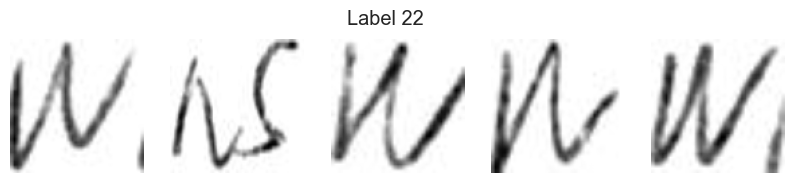

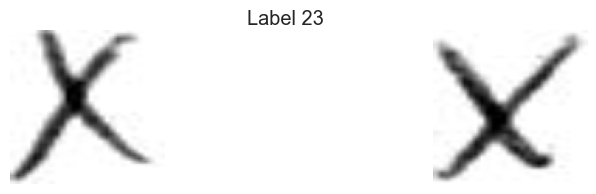

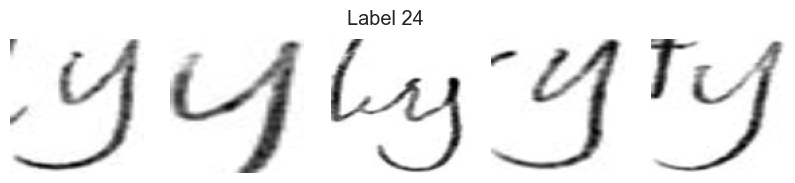

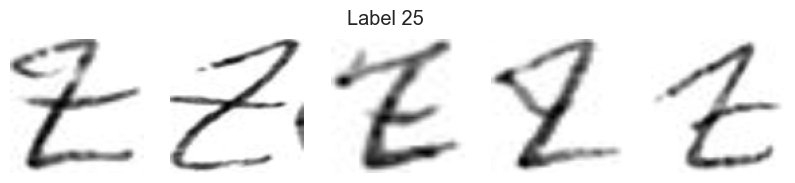

In [27]:
# Group by the label column
grouped = df.groupby('label')

# Function to plot images
def plot_images(images, label, max_images=5):
    plt.figure(figsize=(10, 2))
    plt.suptitle(f'Label {label}')
    for i, img in enumerate(images):
        plt.subplot(1, min(len(images), max_images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

# Loop through each label and plot images
for label, group in grouped:
    images = group['image'].tolist()
    plot_images(images[:5], label)

<h1>Creazione Dataset dei caratteri dei due Manoscritti</h1>

In [16]:
import os
import shutil
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset

# Transform for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Function to load an image and apply preprocessing
def load_image(image_path, device):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image

# Function to classify an image and return class name and confidence
def classify_image(image_path, model, class_names, device):
    image = load_image(image_path, device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        predicted_class_idx = predicted.item()
        # Debugging print statements
        if predicted_class_idx >= len(class_names):
            raise ValueError(f"Predicted class index {predicted_class_idx} is out of range for class names list.")
        class_name = class_names[predicted_class_idx]
        return class_name, confidence.item(), image.squeeze(0)

# Function to calculate dynamic thresholds based on confidences
def calculate_dynamic_thresholds(confidences, class_names, sigma_factor=1):
    confidence_dict = {i: [] for i in range(len(class_names))}
    
    for predicted_class, confidence in confidences:
        class_idx = class_names.index(predicted_class)
        confidence_dict[class_idx].append(confidence)
    
    thresholds = {}
    for class_idx, scores in confidence_dict.items():
        if scores:
            mean_conf = np.mean(scores)
            std_conf = np.std(scores)
            thresholds[class_idx] = max(0.5, mean_conf - sigma_factor * std_conf)
        else:
            thresholds[class_idx] = 0.5  # Fallback value

    return thresholds

# Function to gather confidences for all images in a directory
def gather_confidences(main_folder, model, class_names, device):
    confidences = []

    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith('.png'):
                predicted_class, confidence, _ = classify_image(image_path, model, class_names, device)
                confidences.append((predicted_class, confidence))

    return confidences

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self):
        self.images = []
        self.labels = []

    def add(self, image, label):
        self.images.append(image)
        self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Function to classify images in a directory and load them into a dataset
def classify_images_in_directory(main_folder, model, class_names, dynamic_thresholds, device):
    dataset = ImageDataset()
    
    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith('.jpg'):
                class_name, confidence, image_tensor = classify_image(image_path, model, class_names, device)
                class_idx = class_names.index(class_name)
                confidence_threshold = dynamic_thresholds.get(class_idx, 0.5)
                if confidence >= confidence_threshold:
                    dataset.add(image_tensor, class_idx)
    
    return dataset

# Load the model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights = torch.load(os.path.join('models', 'resnet_experiment6.pth'), map_location=device)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
resnet.to(device)  # Move the model to the correct device
print("Model loaded successfully")

# Paths to input and output folders
main_folder1 = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\dati1'
# Paths to input and output folders
main_folder2 = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\dati2'

# List of class names
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

# Gather confidence scores for all images in the directories
confidencesA = gather_confidences(main_folder1, resnet, class_names, device)
# Calculate dynamic thresholds based on confidence scores
dynamic_thresholdsA = calculate_dynamic_thresholds(confidencesA, class_names)

# Gather confidence scores for all images in the directories
confidencesB = gather_confidences(main_folder2, resnet, class_names, device)
# Calculate dynamic thresholds based on confidence scores
dynamic_thresholdsB = calculate_dynamic_thresholds(confidencesB, class_names)

# Classify the images in the directory and load them into a dataset
datasetA = classify_images_in_directory(main_folder1, resnet, class_names, dynamic_thresholdsA, device)
datasetB = classify_images_in_directory(main_folder2, resnet, class_names, dynamic_thresholdsB, device)

Model loaded successfully
Predicted class index: 11, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 4, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 16, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 6, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 24, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 0, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 19, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 12, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 19, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 12, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 0, Total classes: 25
Model output shape: torch.Size([1, 25])
Predicted class index: 16, Total classes: 2

<h1>Calcolo distanze Manoscritti</h1>

In [28]:
from scipy.spatial.distance import braycurtis

# Funzione per estrarre le caratteristiche
def extract_features(image_path, model, device):
    image = load_image(image_path, device)
    model.eval()
    with torch.no_grad():
        features = model(image)
    return features.cpu().numpy().flatten()

# Funzione per calcolare la distanza euclidea tra due set di caratteristiche
def euclidean_distance(features1, features2):
    return np.linalg.norm(features1 - features2)

# Funzione per calcolare la distanza di Manhattan tra due set di caratteristiche
def manhattan_distance(features1, features2):
    return np.sum(np.abs(features1 - features2))

# Funzione per calcolare la distanza di Bray-Curtis tra due set di caratteristiche
def bray_curtis_distance(features1, features2):
    return braycurtis(features1, features2)

# Carica il modello e i pesi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights = torch.load(os.path.join('models', 'resnet_experiment1.pth'), map_location=device)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
resnet.to(device)

# Calcola le distanze euclidee, di Manhattan e di Bray-Curtis medie tra le lettere dei due dataset
distances_euclidean = {}
distances_manhattan = {}
distances_braycurtis = {}
overall_distances_euclidean = []
overall_distances_manhattan = []
overall_distances_braycurtis = []

for class_name in class_names:
    featuresA = [extract_features(item['image_path'], resnet, device) for item in datasetA if item['class_name'] == class_name]
    featuresB = [extract_features(item['image_path'], resnet, device) for item in datasetB if item['class_name'] == class_name]
    
    if featuresA and featuresB:
        dist_euclidean = []
        dist_manhattan = []
        dist_braycurtis = []
        for fa in featuresA:
            for fb in featuresB:
                de = euclidean_distance(fa, fb)
                dm = manhattan_distance(fa, fb)
                dbc = bray_curtis_distance(fa, fb)
                dist_euclidean.append(de)
                dist_manhattan.append(dm)
                dist_braycurtis.append(dbc)
                overall_distances_euclidean.append(de)
                overall_distances_manhattan.append(dm)
                overall_distances_braycurtis.append(dbc)
        if dist_euclidean:
            distances_euclidean[class_name] = np.mean(dist_euclidean)
        if dist_manhattan:
            distances_manhattan[class_name] = np.mean(dist_manhattan)
        if dist_braycurtis:
            distances_braycurtis[class_name] = np.mean(dist_braycurtis)

# Normalizza le distanze da 1 a 10
labels = list(distances_euclidean.keys())
values_euclidean = list(distances_euclidean.values())
values_manhattan = list(distances_manhattan.values())
values_braycurtis = list(distances_braycurtis.values())

scaler_euclidean = MinMaxScaler(feature_range=(1, 10))
values_normalized_euclidean = scaler_euclidean.fit_transform(np.array(values_euclidean).reshape(-1, 1)).flatten()

scaler_manhattan = MinMaxScaler(feature_range=(1, 10))
values_normalized_manhattan = scaler_manhattan.fit_transform(np.array(values_manhattan).reshape(-1, 1)).flatten()

scaler_braycurtis = MinMaxScaler(feature_range=(1, 10))
values_normalized_braycurtis = scaler_braycurtis.fit_transform(np.array(values_braycurtis).reshape(-1, 1)).flatten()

# Calcola la distanza complessiva media e normalizzala da 1 a 10
overall_distance_mean_euclidean = np.mean(overall_distances_euclidean)
overall_distance_normalized_euclidean = scaler_euclidean.transform([[overall_distance_mean_euclidean]])[0][0]

overall_distance_mean_manhattan = np.mean(overall_distances_manhattan)
overall_distance_normalized_manhattan = scaler_manhattan.transform([[overall_distance_mean_manhattan]])[0][0]

overall_distance_mean_braycurtis = np.mean(overall_distances_braycurtis)
overall_distance_normalized_braycurtis = scaler_braycurtis.transform([[overall_distance_mean_braycurtis]])[0][0]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

axes[0].bar(labels, values_normalized_euclidean, color='skyblue')
axes[0].set_xlabel('Letters')
axes[0].set_ylabel('Normalized Euclidean Distance')
axes[0].set_title('Normalized Euclidean Distance between Corresponding Letters in Two Datasets')

axes[1].bar(labels, values_normalized_manhattan, color='lightgreen')
axes[1].set_xlabel('Letters')
axes[1].set_ylabel('Normalized Manhattan Distance')
axes[1].set_title('Normalized Manhattan Distance between Corresponding Letters in Two Datasets')

axes[2].bar(labels, values_normalized_braycurtis, color='lightcoral')
axes[2].set_xlabel('Letters')
axes[2].set_ylabel('Normalized Bray-Curtis Distance')
axes[2].set_title('Normalized Bray-Curtis Distance between Corresponding Letters in Two Datasets')

plt.tight_layout()
plt.show()

# Stampa la distanza complessiva normalizzata
print(f"Overall normalized Euclidean distance: {overall_distance_normalized_euclidean:.2f}")
print(f"Overall normalized Manhattan distance: {overall_distance_normalized_manhattan:.2f}")
print(f"Overall normalized Bray-Curtis distance: {overall_distance_normalized_braycurtis:.2f}")

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

<h1>Estrazione Vettori Feature<h1>

In [39]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
import json

# Ensure the dataframe includes the 'subject' column
df['subject'] = df.apply(lambda row: row['subject'], axis=1)

# Dictionary mapping numbers to letters, excluding 'j'
letters = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
num_to_letter = {i: letter for i, letter in enumerate(letters)}

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')
        label = row['label_int']
        subject = row['subject']

        if self.transform:
            image = self.transform(image)

        return image, label, subject

def collate_fn(batch):
    images, labels, subjects = zip(*batch)
    return torch.stack(images), torch.tensor(labels), subjects

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    subjects = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for batch in dataloader:
            inputs, lbls, subs = batch
            inputs = inputs.to(device)
            feats = model.extract_features(inputs)
            features.extend(feats.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
            subjects.extend(subs)
    return np.array(features), np.array(labels), np.array(subjects)

def save_features(features, labels, subjects, filename):
    data = []
    for feature, label, subject in zip(features, labels, subjects):
        letter = num_to_letter[label]
        data.append({
            'subject': subject,
            'letter': letter,
            'features': json.dumps(feature.tolist())
        })
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

# Prepare data transformation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Load data and prepare datasets
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df['label_int'] = df['label'].apply(lambda x: np.argmax(x))

# Split dataset into training and test sets
df_train, df_test = create_train_test_dataframe(df)
train_dataset = CustomDataset(df_train, transform=val_transform)
test_dataset = CustomDataset(df_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Load the trained ResNet model
class GenericModel(LetterClassifier):
    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

    def extract_features(self, x):
        self.model.eval()
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features

model = GenericModel('resnet')
model_weights = torch.load(os.path.join('models', f'resnet_experiment6.pth'))
model.load_state_dict(model_weights, strict=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract and save features for training set
train_features, train_labels, train_subjects = extract_features(model, train_loader)
save_features(train_features, train_labels, train_subjects, 'featureVectors/train_features2.csv')

# Extract and save features for test set
test_features, test_labels, test_subjects = extract_features(model, test_loader)
save_features(test_features, test_labels, test_subjects, 'featureVectors/test_features2.csv')

print("Training and test features extracted and saved to 'train_features.csv' and 'test_features.csv'")



Train set: (14680, 5), Test set: (3671, 5)
Training and test features extracted and saved to 'train_features.csv' and 'test_features.csv'
